# New Measure - Proprotion of MDI from All Inhalers

## Rationale


The NHS 10 year plan comits the NHS to reduce harmful enviromental emissions. One way of doing this is to shift from Metered Dose Inhalers (MDI) to Dry Powdered Inhalers (DPI). This notebook is a prototype for modelling the current prescribing patterns in England.

## Proposed Measure

### Title
Proprotion of MDI items prescribed as a total of all inhalers items

### Description
Proprotion of MDIs prescribed as a total of all inhalers from the respiratory chapter in the BNF

### Why it matters
The NHS has comitted to reducing enviromental emissions by x% by 20xx. An estimated x% of emissions come from inhalers. Dry pwoder inhalers (DPIs) are less harmful to the enviroment than traditional metered dose inhalers (MDIs) and the NHS long term plan supports the use of DPI where it is clinically appropriate. NICE have produced an [inhaler decision aid](https://www.nice.org.uk/guidance/ng80/resources/inhalers-for-asthma-patient-decision-aid-pdf-6727144573) to faciltiate decisons about inhalers
You can read more about this measure on our blog [here](https://docs.google.com/document/d/1OQeuHV0AKB8VG87DUcUSjaj7Dre3jKJ7oIjRokaS-uI/edit)

## Numerators & Denominators
They can be viewed here on this [google sheet](https://docs.google.com/spreadsheets/d/1aZGJkN-HF0PrYqmWpIdr72J9sVZGpLm2b1-T-ooje3g/edit#gid=0) Correct as of prescribing data May 2019.  At OpenPrescribing we use live automated code and this should always be consulted as the current reference. Branded Inhalers or BNF codes released prior to x 2019 will not be included on this spreadsheet.

## SQL and Mock up

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import matplotlib.gridspec as gridspec

In [2]:
## Here we query our prescribing file to create a dataframe of all inhaler prescribing
sql = '''
SELECT
  presc.month,
  pct,
  pract.name,
  presc.practice,
  SUM(
  IF
    (form_route='powderinhalation.inhalation',
      ##from dmd, identifies a DPI
      items,
      0)) AS dpi,
  SUM(
  IF
    (form_route='pressurizedinhalation.inhalation',
      ##from dmd, identifies a MDI
      items,
      0)) AS mdi,
  SUM(items) AS totalinhalers
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
LEFT JOIN
  ebmdatalab.hscic.practices AS pract
ON
  presc.practice=pract.code
LEFT JOIN
  # is this join in the right place  review
  ebmdatalab.hscic.practice_statistics_all_years AS stat
ON
  presc.practice = stat.practice
  AND presc.month = stat.month
LEFT JOIN
  ebmdatalab.dmd.form_dose AS dmd
ON
  presc.bnf_code=dmd.bnf_code
WHERE
  presc.bnf_code LIKE "030%"
  AND (form_route="powderinhalation.inhalation"
    OR form_route= "pressurizedinhalation.inhalation")
    AND setting = 4 
    AND pct != "112"
GROUP BY
  month,
  pct,
  name,
  practice
  '''

df1 = bq.cached_read(sql, csv_path='df1.csv', use_cache=True)
df1['month'] = pd.to_datetime(df1['month'])
df1.head(5)

,month,pct,name,practice,dpi,mdi,totalinhalers
0,2015-08-01,00V,PEEL GPS DR CHACKO,P83030,63,227,290
1,2015-08-01,12F,HAMILTON MED CTR,N85021,147,260,407
2,2015-08-01,00Y,WOODLANDS MEDICAL PRACTICE,P85010,519,680,1199
3,2015-08-01,09J,IVY BOWER SURGERY,G82156,118,118,236
4,2015-08-01,04D,POTTERGATE SURGERY,Y04945,140,222,362


In [3]:
##here we print a csv file of numerator and denominators so interested users can consult a google sheet with the list
sql = '''
SELECT DISTINCT
  bnf_name,
  presc.bnf_code,
  form_route
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
JOIN
  ebmdatalab.dmd.form_dose AS dmd
ON
  presc.bnf_code=dmd.bnf_code
WHERE
  presc.bnf_code LIKE "030%"
  AND (form_route="powderinhalation.inhalation"
    OR form_route= "pressurizedinhalation.inhalation")
GROUP BY
  bnf_name,
  presc.bnf_code,
  form_route
  '''

df2 = bq.cached_read(sql, csv_path='df2_num_denom.csv', use_cache=True)

df2.nunique()

bnf_name      486
bnf_code      321
form_route      2
dtype: int64

There are BNF names that are duplicated due to the white space issue. Lets strip this out.

In [4]:
df2.bnf_name = df2.bnf_name.str.rstrip()
df2.head()

,bnf_name,bnf_code,form_route
0,Incruse Ellipta_Inh 55mcg (30D),0301020T0BBAAAA,powderinhalation.inhalation
1,Formoterol Fumar_Inh 12mcg (100D) CFF,0301011E0AAADAD,pressurizedinhalation.inhalation
2,Sirdupla_Inh 250mcg/25mcg (120D),0302000N0BFABBG,pressurizedinhalation.inhalation
3,Tiotropium_Pdr For Inh Cap 18mcg + Dev,0301020Q0AAAAAA,powderinhalation.inhalation
4,Sod Cromoglicate_Inha 5mg (112D) CFF,0303010Q0AAANAN,pressurizedinhalation.inhalation


In [5]:
df2.nunique()

bnf_name      340
bnf_code      321
form_route      2
dtype: int64

In [6]:
df2.to_csv("inhaler_num_denom_final.csv")

In [7]:
df1["measure_value"] = (df1["mdi"] / df1["totalinhalers"])*100
df1.head()

,month,pct,name,practice,dpi,mdi,totalinhalers,measure_value
0,2015-08-01,00V,PEEL GPS DR CHACKO,P83030,63,227,290,78.275862
1,2015-08-01,12F,HAMILTON MED CTR,N85021,147,260,407,63.882064
2,2015-08-01,00Y,WOODLANDS MEDICAL PRACTICE,P85010,519,680,1199,56.713928
3,2015-08-01,09J,IVY BOWER SURGERY,G82156,118,118,236,50.000000
4,2015-08-01,04D,POTTERGATE SURGERY,Y04945,140,222,362,61.325967


In [8]:
df1_2019 = df1.loc[df1['month'] >= "2019-04-01"]
df1_2019.head()

,month,pct,name,practice,dpi,mdi,totalinhalers,measure_value
77412,2019-06-01,01R,EARNSWOOD MEDICAL CENTRE,N81053,880,995,1875,53.066667
77413,2019-06-01,12F,GREASBY GROUP PRACTICE,N85032,269,408,677,60.265879
77414,2019-06-01,02E,SPRINGFIELDS MEDICAL CENTRE,N81036,253,387,640,60.468750
77415,2019-06-01,02E,PENKETH HEALTH CENTRE,N81020,445,772,1217,63.434675
77416,2019-06-01,00D,EAST DURHAM MEDICAL GROUP,A83057,1415,2096,3511,59.698092


In [9]:
df1_2019["measure_value"] = (df1_2019["mdi"] / df1_2019["totalinhalers"])*100
df1_2019.head(5)

C:\Users\bmackenna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,month,pct,name,practice,dpi,mdi,totalinhalers,measure_value
77412,2019-06-01,01R,EARNSWOOD MEDICAL CENTRE,N81053,880,995,1875,53.066667
77413,2019-06-01,12F,GREASBY GROUP PRACTICE,N85032,269,408,677,60.265879
77414,2019-06-01,02E,SPRINGFIELDS MEDICAL CENTRE,N81036,253,387,640,60.468750
77415,2019-06-01,02E,PENKETH HEALTH CENTRE,N81020,445,772,1217,63.434675
77416,2019-06-01,00D,EAST DURHAM MEDICAL GROUP,A83057,1415,2096,3511,59.698092


In [10]:
by_pct_df1 = df1.groupby(['pct', 'month'], as_index=False).sum()
by_pct_df1.head()

,pct,month,dpi,mdi,totalinhalers,measure_value
0,00C,2010-08-01,2852,5367,8219,808.385564
1,00C,2010-09-01,3071,5864,8935,802.380833
2,00C,2010-10-01,2888,5719,8607,825.627451
3,00C,2010-11-01,3070,5897,8967,811.343437
4,00C,2010-12-01,3524,6557,10081,806.247535


In [11]:
by_pct_df1["measure_value"] = (by_pct_df1["mdi"] / by_pct_df1["totalinhalers"])*100

In [12]:
by_pct_df1_2019 = df1[df1['month'] >= "2019-04-01"].groupby('pct').sum().reset_index()
by_pct_df1_2019.head()

,pct,dpi,mdi,totalinhalers,measure_value
0,00C,14351,20808,35159,1963.091091
1,00D,51905,83622,135527,6942.994190
2,00J,34572,55328,89900,5560.068924
3,00K,42584,75859,118443,6258.610383
4,00L,55217,62301,117518,6735.462353


In [13]:
by_pct_df1_2019["measure_value"] = (by_pct_df1_2019["mdi"] / by_pct_df1_2019["totalinhalers"])*100

## Deciles

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


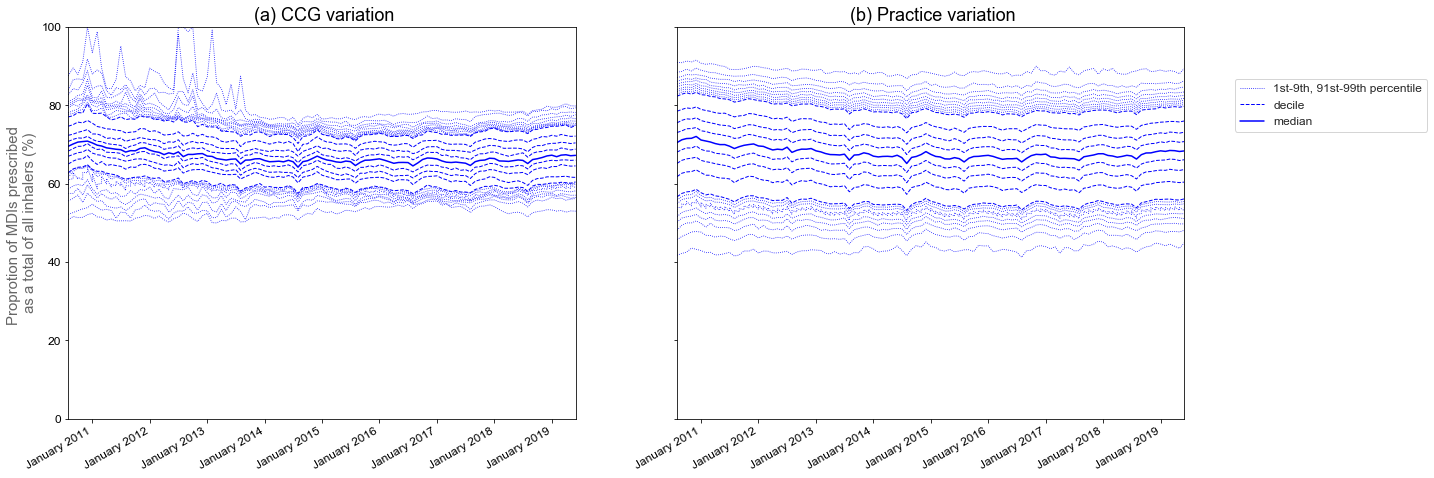

In [14]:
f = plt.figure(figsize=(20,8))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 

# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)

charts.deciles_chart(
    by_pct_df1,
    period_column='month',
    column='measure_value',
    title=" (a) CCG variation",
    ylabel="Proprotion of MDIs prescribed \n as a total of all inhalers (%) ",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot, 
) 


charts.deciles_chart(
    df1,
    period_column='month',
    column='measure_value',
    title=" (b) Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot,
) 

plt.ylim(0, 100)
plt.show()

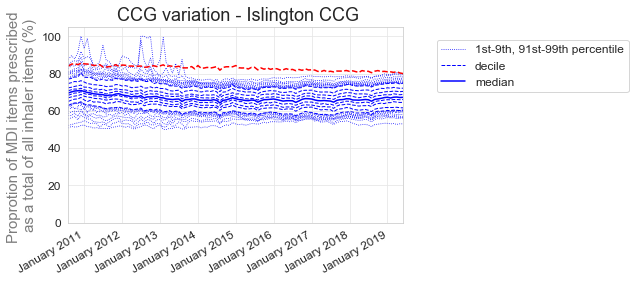

In [15]:
###here we chart a ccg example
charts.deciles_chart(
    by_pct_df1,
    period_column='month',
    column='measure_value',
    title=" CCG variation - Islington CCG",
    ylabel="Proprotion of MDI items prescribed \n as a total of all inhaler items (%) ",
    show_outer_percentiles=True,
    show_legend=True 
) 


#add in example CCG (Islington - 08h)
df_subject = by_pct_df1.loc[by_pct_df1['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['measure_value'], 'r--')
plt.show()

## Maps - Geographic Variation

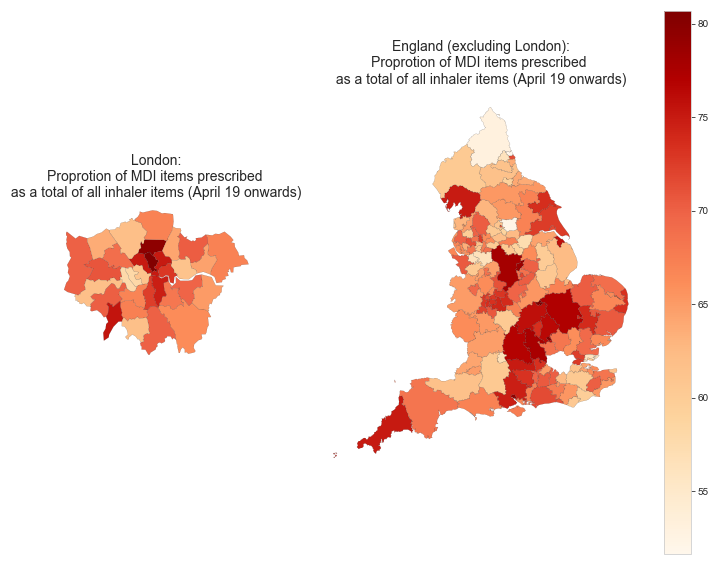

In [16]:
plt.figure(figsize=(12,10))
plt = maps.ccg_map(by_pct_df1_2019, title="Proprotion of MDI items prescribed \n as a total of all inhaler items (April 19 onwards) ", column='measure_value', cartogram=False, separate_london=True)
plt.show()

### Version 2

In [17]:
## Here we are implementing with a new view prepared by Peter which is better suited for deployment to the live site. 

sql = '''
SELECT
  presc.month,
  pct,
  pract.name,
  presc.practice,
  SUM(
  IF
    (form_route='powderinhalation.inhalation',
      ##from dmd, identifies a DPI
      items,
      0)) AS dpi,
  SUM(
  IF
    (form_route='pressurizedinhalation.inhalation',
      ##from dmd, identifies a MDI
      items,
      0)) AS mdi
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
LEFT JOIN
  ebmdatalab.hscic.practices AS pract
ON
  presc.practice=pract.code
LEFT JOIN
  # is this join in the right place  review
  ebmdatalab.hscic.practice_statistics_all_years AS stat
ON
  presc.practice = stat.practice
  AND presc.month = stat.month
LEFT JOIN
  ebmdatalab.staging_measures.vw__chapter_3_dmd_objs_with_dose_route AS dmd ##this is the new view in BQ
ON
  presc.bnf_code=dmd.bnf_code
WHERE
setting = 4 
GROUP BY
  month,
  pct,
  name,
  practice
  '''

df3 = bq.cached_read(sql, csv_path='df3.csv', use_cache=True)
df3['month'] = pd.to_datetime(df3['month'])
df3.head(5)

,month,pct,name,practice,dpi,mdi
0,2015-08-01,11N,PORT VIEW SURGERY,L82066,353,839
1,2015-08-01,11N,WADEBRIDGE & CAMEL ESTUARY PRACTICE,L82004,386,2774
2,2015-08-01,09W,BORSTAL VILLAGE SURGERY,G82711,139,485
3,2015-08-01,08M,NEWHAM MEDICAL CENTRE,F84669,166,1536
4,2015-08-01,07Y,CROSSLANDS SURGERY,E85114,187,1984


In [18]:
df3["totalinhalers"] = (df3["mdi"] + df3["dpi"])

In [19]:
df3["measure_value"] = (df3["mdi"] / df3["totalinhalers"])*100
df3.head()

,month,pct,name,practice,dpi,mdi,totalinhalers,measure_value
0,2015-08-01,11N,PORT VIEW SURGERY,L82066,353,839,1192,70.385906
1,2015-08-01,11N,WADEBRIDGE & CAMEL ESTUARY PRACTICE,L82004,386,2774,3160,87.784810
2,2015-08-01,09W,BORSTAL VILLAGE SURGERY,G82711,139,485,624,77.724359
3,2015-08-01,08M,NEWHAM MEDICAL CENTRE,F84669,166,1536,1702,90.246769
4,2015-08-01,07Y,CROSSLANDS SURGERY,E85114,187,1984,2171,91.386458


In [20]:
by_pct_df3 = df3.groupby(['pct', 'month'], as_index=False).sum()
by_pct_df3.head()

,pct,month,dpi,mdi,totalinhalers,measure_value
0,00C,2010-08-01,4849,12656,17505,889.765028
1,00C,2010-09-01,5255,13855,19110,887.408806
2,00C,2010-10-01,4942,13974,18916,903.543005
3,00C,2010-11-01,5305,14593,19898,896.268066
4,00C,2010-12-01,6044,16363,22407,890.117628


In [21]:
by_pct_df3["measure_value"] = (by_pct_df3["mdi"] / by_pct_df3["totalinhalers"])*100
by_pct_df3.head()

,pct,month,dpi,mdi,totalinhalers,measure_value
0,00C,2010-08-01,4849,12656,17505,72.299343
1,00C,2010-09-01,5255,13855,19110,72.501308
2,00C,2010-10-01,4942,13974,18916,73.873969
3,00C,2010-11-01,5305,14593,19898,73.339029
4,00C,2010-12-01,6044,16363,22407,73.026286


### Deciles Plot

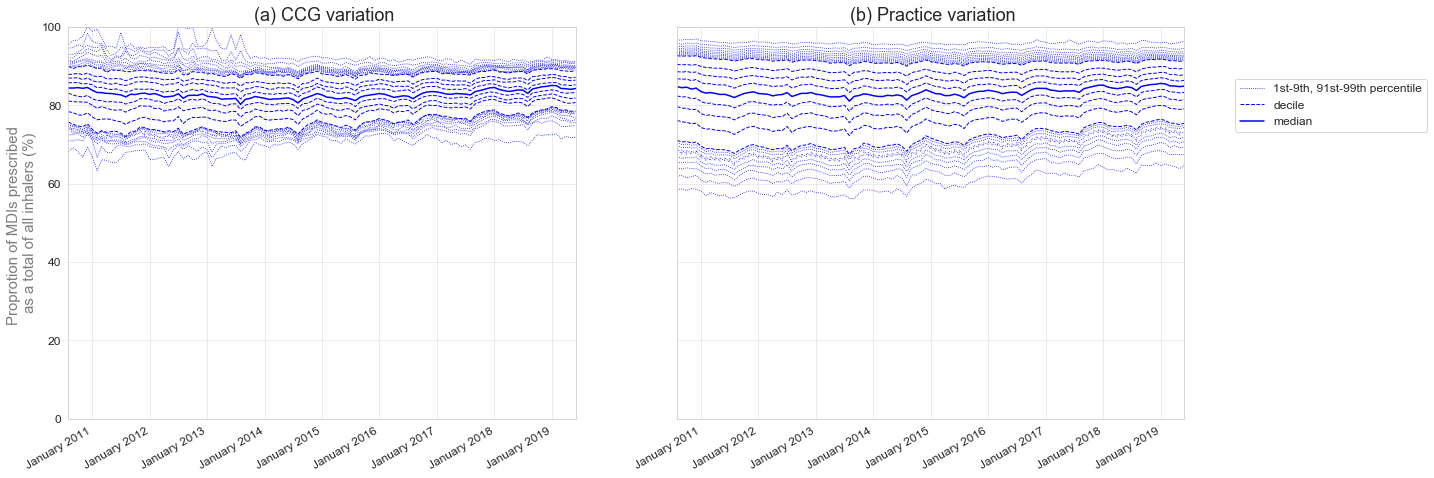

In [22]:
f = plt.figure(figsize=(20,8))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 

# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)

charts.deciles_chart(
    by_pct_df3,
    period_column='month',
    column='measure_value',
    title=" (a) CCG variation",
    ylabel="Proprotion of MDIs prescribed \n as a total of all inhalers (%) ",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot, 
) 


charts.deciles_chart(
    df3,
    period_column='month',
    column='measure_value',
    title=" (b) Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot,
) 

plt.ylim(0, 100)
plt.show()

### Without Salbutamol

A better strategy for switching salbutamol is to go from large volum to low volume MDI and not switch to DPI. We need to keep message simple so it may have to be switch apart from salbutamol. Other strategies such as working with manufavturers and community pharmacy chains may acheive the low volume switch in a more effiecient manner

In [23]:
## Here we are implementing with a new view prepared by Peter
sql = '''
SELECT
  presc.month,
  pct,
  pract.name,
  presc.practice,
  SUM(
  IF
    (form_route='powderinhalation.inhalation',
      ##from dmd, identifies a DPI
      items,
      0)) AS dpi,
  SUM(
  IF
    (form_route='pressurizedinhalation.inhalation',
      ##from dmd, identifies a MDI
      items,
      0)) AS mdi
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
LEFT JOIN
  ebmdatalab.hscic.practices AS pract
ON
  presc.practice=pract.code
LEFT JOIN
  # is this join in the right place  review
  ebmdatalab.hscic.practice_statistics_all_years AS stat
ON
  presc.practice = stat.practice
  AND presc.month = stat.month
LEFT JOIN
  ebmdatalab.staging_measures.vw__chapter_3_dmd_objs_with_dose_route AS dmd
ON
  presc.bnf_code=dmd.bnf_code
WHERE
dmd.bnf_code NOT LIKE "0301011R0%" AND ##this is salbutamol bnf code
setting = 4 
GROUP BY
  month,
  pct,
  name,
  practice
  '''

df4 = bq.cached_read(sql, csv_path='df4.csv', use_cache=True)
df4['month'] = pd.to_datetime(df4['month'])
df4.head(5)

,month,pct,name,practice,dpi,mdi
0,2015-08-01,03K,THE CENTRAL SURGERY BARTON,B81005,1208,1098
1,2015-08-01,06P,LEA VALE MEDICAL PRACTICE,E81032,660,648
2,2015-08-01,15M,STAFFA HEALTH,C81029,807,1958
3,2015-08-01,06L,FRAMFIELD HOUSE SURGERY,D83057,462,508
4,2015-08-01,11X,NORTH CURRY,L85037,168,154


In [24]:
df4["totalinhalers"] = (df4["mdi"] + df4["dpi"])

In [25]:
df4["measure_value"] = (df4["mdi"] / df4["totalinhalers"])*100
df4.head()

,month,pct,name,practice,dpi,mdi,totalinhalers,measure_value
0,2015-08-01,03K,THE CENTRAL SURGERY BARTON,B81005,1208,1098,2306,47.614918
1,2015-08-01,06P,LEA VALE MEDICAL PRACTICE,E81032,660,648,1308,49.541284
2,2015-08-01,15M,STAFFA HEALTH,C81029,807,1958,2765,70.813743
3,2015-08-01,06L,FRAMFIELD HOUSE SURGERY,D83057,462,508,970,52.371134
4,2015-08-01,11X,NORTH CURRY,L85037,168,154,322,47.826087


In [26]:
by_pct_df4 = df4.groupby(['pct', 'month'], as_index=False).sum()
by_pct_df4.head()

,pct,month,dpi,mdi,totalinhalers,measure_value
0,00C,2010-08-01,4608,4726,9334,629.162167
1,00C,2010-09-01,4956,4901,9857,616.317660
2,00C,2010-10-01,4671,4742,9413,639.651846
3,00C,2010-11-01,5017,5017,10034,609.878796
4,00C,2010-12-01,5674,5439,11113,615.239514


In [27]:
by_pct_df4["measure_value"] = (by_pct_df4["mdi"] / by_pct_df4["totalinhalers"])*100
by_pct_df4.head()

,pct,month,dpi,mdi,totalinhalers,measure_value
0,00C,2010-08-01,4608,4726,9334,50.632098
1,00C,2010-09-01,4956,4901,9857,49.721010
2,00C,2010-10-01,4671,4742,9413,50.377138
3,00C,2010-11-01,5017,5017,10034,50.000000
4,00C,2010-12-01,5674,5439,11113,48.942680


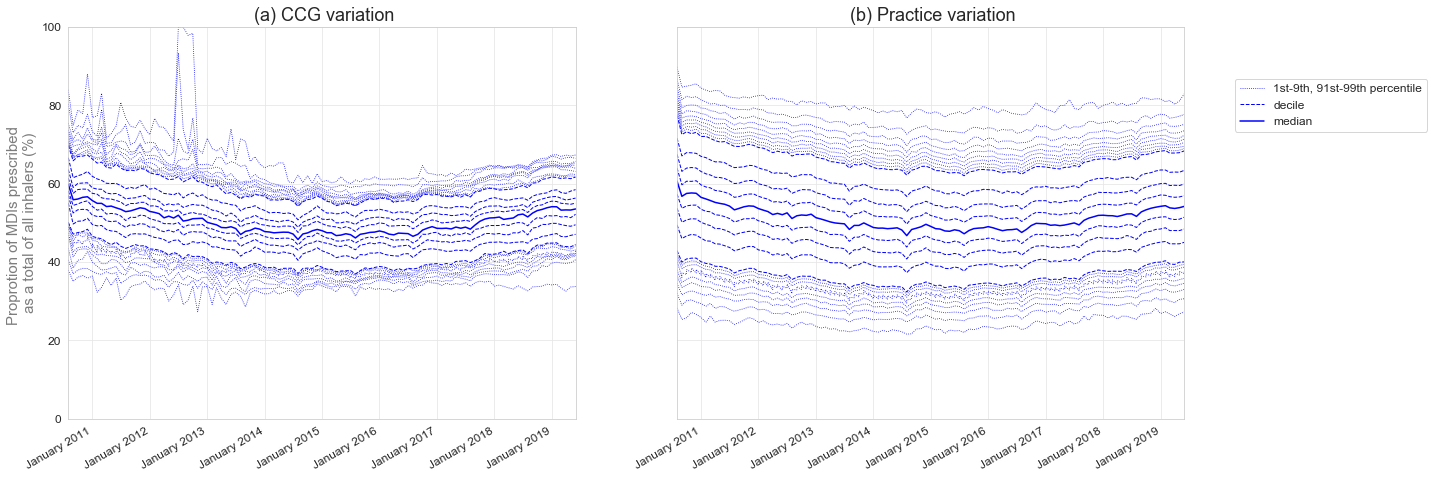

In [28]:
f = plt.figure(figsize=(20,8))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 

# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)

charts.deciles_chart(
    by_pct_df4,
    period_column='month',
    column='measure_value',
    title=" (a) CCG variation",
    ylabel="Proprotion of MDIs prescribed \n as a total of all inhalers (%) ",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot, 
) 


charts.deciles_chart(
    df4,
    period_column='month',
    column='measure_value',
    title=" (b) Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot,
) 

plt.ylim(0, 100)
plt.show()